In [1]:
%matplotlib inline

import gym
import numpy as np
import matplotlib
import sys

from collections import defaultdict

if '../' not in sys.path:
    sys.path.append('../')
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

### PredictとControlの違い

Predictは, Policyを用いて状態価値関数$V$を求める.

Controlは, Policy$\pi$を用いて, 新たなPolicy$\pi$と状態価値関数を求める

ゴール: 政策$\pi$の元での経験のエピソードから$v_{\pi}$を学習することがモンテカルロ政策評価の問題

あるエピソードでのある状態に出会って、そこからの累積報酬$G_{t}$を計算し,

状態価値関数は以下のような期待リターンとする
$v_{\pi}(s) = \mathbb{E}_{\pi}[G_{t} \, |\,  S_t = s]$

モンテカルロ政策評価は期待リターンの代わりに経験平均リターンを使う

In [2]:
env = BlackjackEnv()

In [55]:
def mc_prediction(policy, env, num_episidoes, discount_factor=1.):
    """
    Monte Carlo prediction algo.
    Calc the value func for a given policy using sampling.
    
    Args:
        num_episodes: Number of episodes to sample.
    Returns:
        A dictionary that maps from state -> value.
        The state i sa tuple and the value is a float.
    """
    
    # Keeps track of sum and count of returns for each state
    # to calc an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # Implement this!
    for i_epis in range(num_episidoes):
        state = env.reset()
        episodes = []
        
        # Generate Episode.
        # An episode is an array of (state, action, reward) tuples
        for t in range(100):
            # ✗ action = policy(state)
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episodes.append((state, action, reward))
            
            if done:
                break
            state = next_state
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        # 理由はまだわかってないけど, setを使うことで同じ状態はなくなるね.  
        # 1回通ったことが重要？
        # あの状態に通ったときの、累積報酬の平均
        states_in_episode = set([ep[0] for ep in episodes])
        for state in states_in_episode:
            
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i, x in enumerate(episodes) if x[0] == state)
            # The first time-step t that state s is visited in an episode,
            # Gt = R_{t+1} + \gamma R_{t+2} + ...
            G = sum(discount_factor**T * R[2] 
                    for T, R in enumerate(episodes[first_occurence_idx:]))
            
            # Calc average return for this state over all sampled episodes
            
            returns_count[state] += 1
            
            """
            returns_sum[state] += G
            V[state] = returns_sum[state] / returns_count[state]
            """
            V[state] += 1. / returns_count[state] * (G - V[state])
    return V

In [56]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array([1., 0.]) if score >= 20 else np.array([0., 1.])

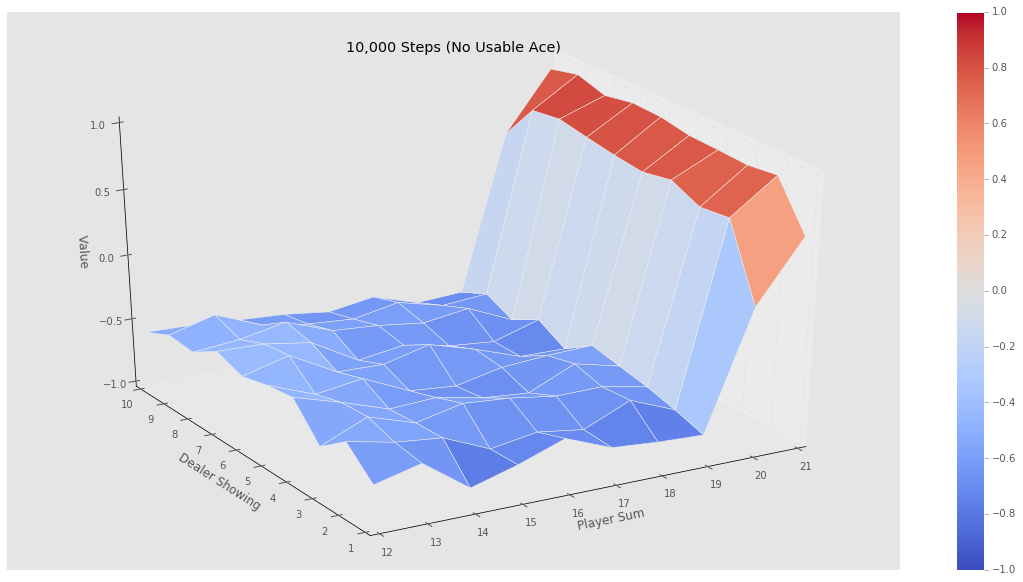

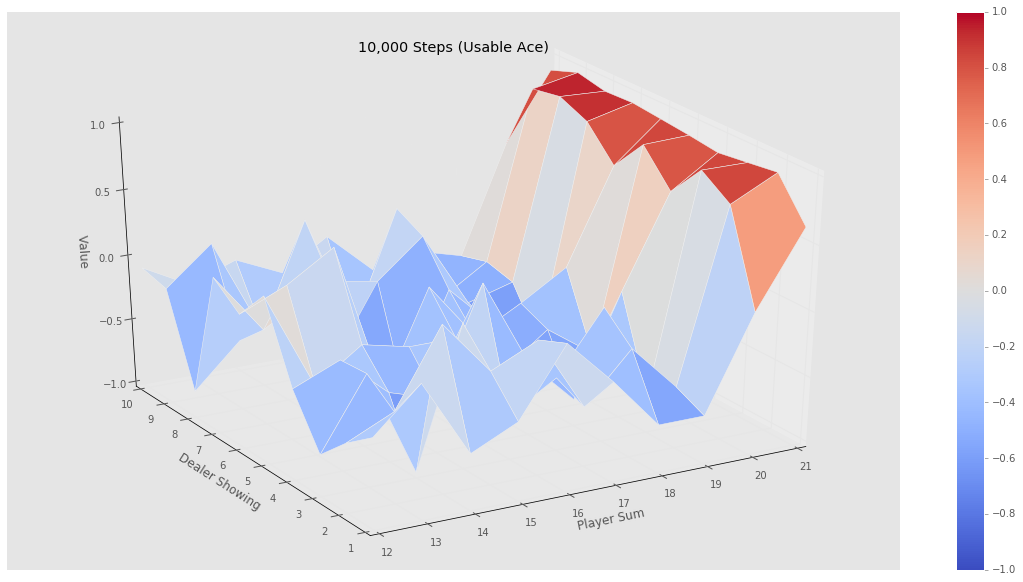

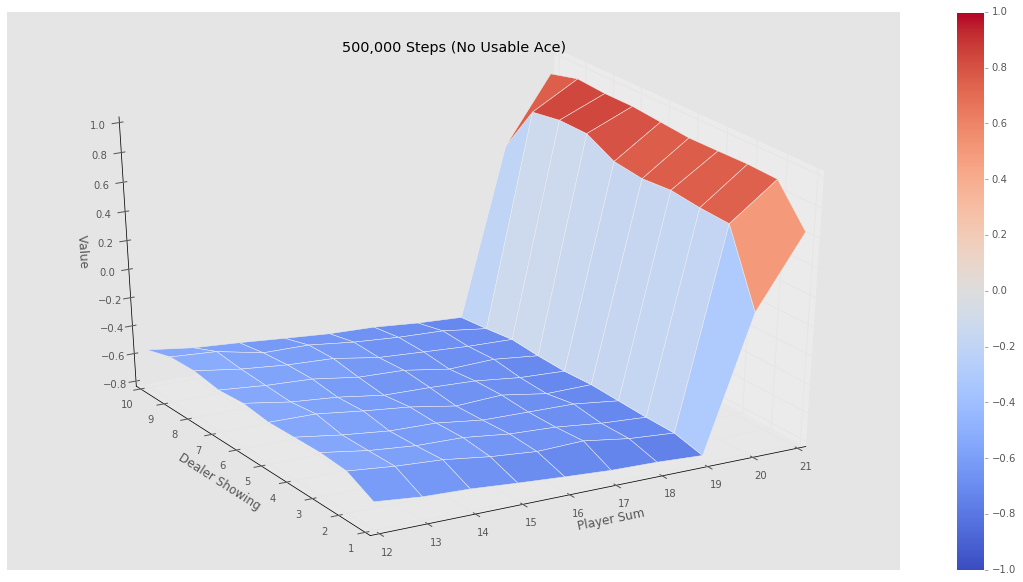

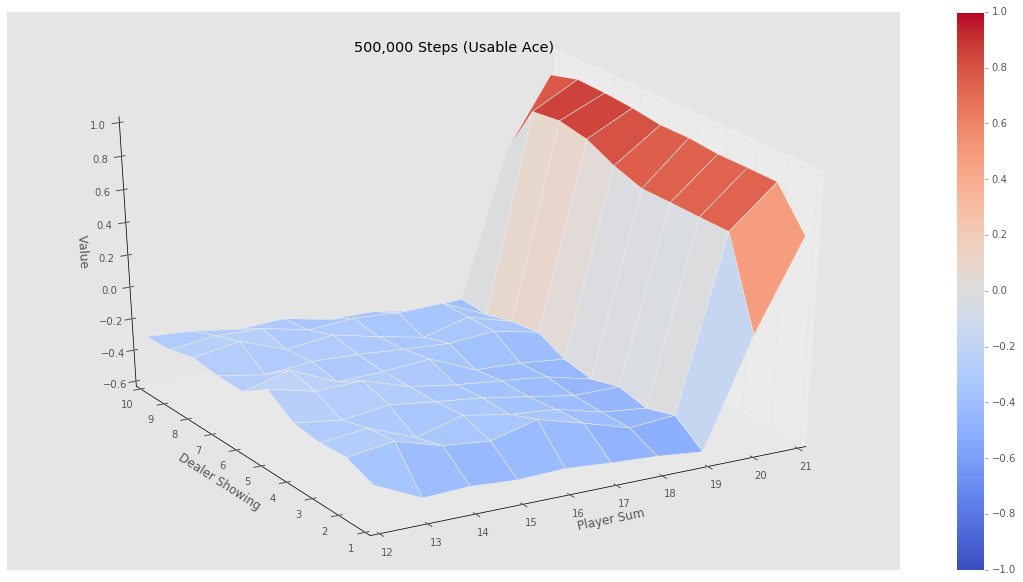

In [57]:
V_10k = mc_prediction(sample_policy, env, num_episidoes=10000)
plotting.plot_value_function(V_10k, title='10,000 Steps')

V_500k = mc_prediction(sample_policy, env, num_episidoes=500000)
plotting.plot_value_function(V_500k, title='500,000 Steps')

In [123]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    # \pi(a|s) is action_values
    def policy_fn(observation):
        action_values = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])  # a* = argmax Q(S, a), where S is known.
        action_values[best_action] += 1 - epsilon
        return action_values
    return policy_fn

In [144]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1., epsilon=0.1):
    returns_count = defaultdict(float)
    returns_sum = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    # Implement this!!
    for i_episode in range(1, num_episodes + 1):
        
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="", flush=True)
        
        state = env.reset()
        episodes = []  # (state1, action1, reward1), ...
        for t in range(1, 100):
                probs = policy(state)  # action probs
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, info = env.step(action)

                episodes.append((state, action, reward))
                if done:
                    break
                state = next_state
                
        state_action_episodes = set([(tuple(e[0]), e[1]) for e in episodes])
        for state, action in state_action_episodes:
            first_occurrence_idx = next(i for i, e in enumerate(episodes) \
                                        if e[0] == state and e[1] == action)
            G = sum([e[2] * discount_factor**i for i, e in enumerate(
                    episodes[first_occurrence_idx:])])
            
            returns_count[(state, action)] += 1
            Q[state][action] += 1. / returns_count[(state, action)] * (G - Q[state][action])
            # Q[state,action] += 1. / returns_count[(state, action)] * (G - Q[state,action])
        epsilon = 1. / t
        policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    return Q, policy

In [145]:
print(state)

(20, 1, False)


In [146]:
print(action)

NameError: name 'action' is not defined

### TD Learning

TDはbootstrappingによって, 不完全なエピソードから学習する.

TDは推測から推測へと更新する.

In [147]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, epsilon=0.1)

Episode 100000/100000.

ゴール: 政策$\pi$の元で逐次に経験から$v_{\pi}$を学習することがTDの政策評価

増加全訪問モンテカルロであり, 現時点でのリターン$G_{t}$へ向かって$V(S_t)$を更新する.
$$V(S_t) \leftarrow V(S_t) + \alpha(G_t - V(S_t))$$

例えば, シンプルなTDアルゴリズムで, TD(0)では, 

推定リターン$R_{t+1} + \gamma V(S_{t+1})$へ向かって$V(S_{t})$を更新する

$$V(S_t) \leftarrow V(S_t) + \alpha(R_{t+1} + \gamma V(S_{t+1}) - V(S_t))$$

**TD Target**: $R_{t+1} + \gamma V(S_{t+1})$     
**TD Error**: $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$

33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333

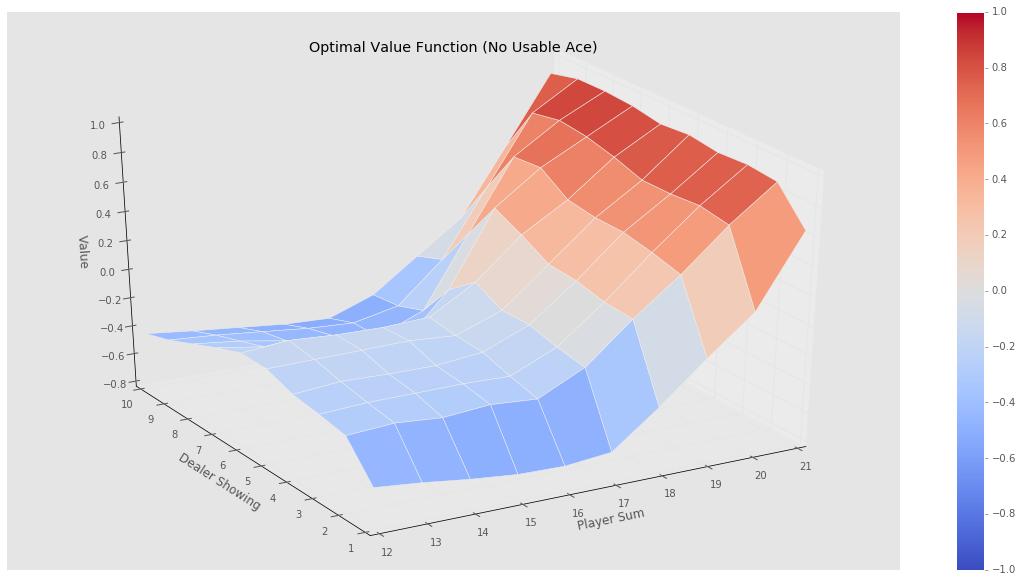

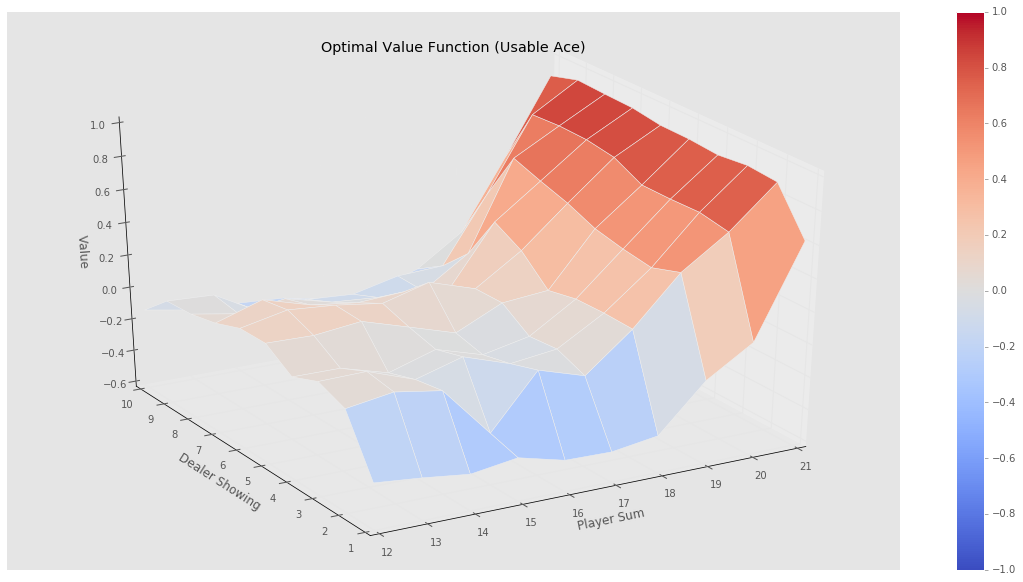

In [135]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
    print(len(state), end='')
plotting.plot_value_function(V, title="Optimal Value Function")

33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333

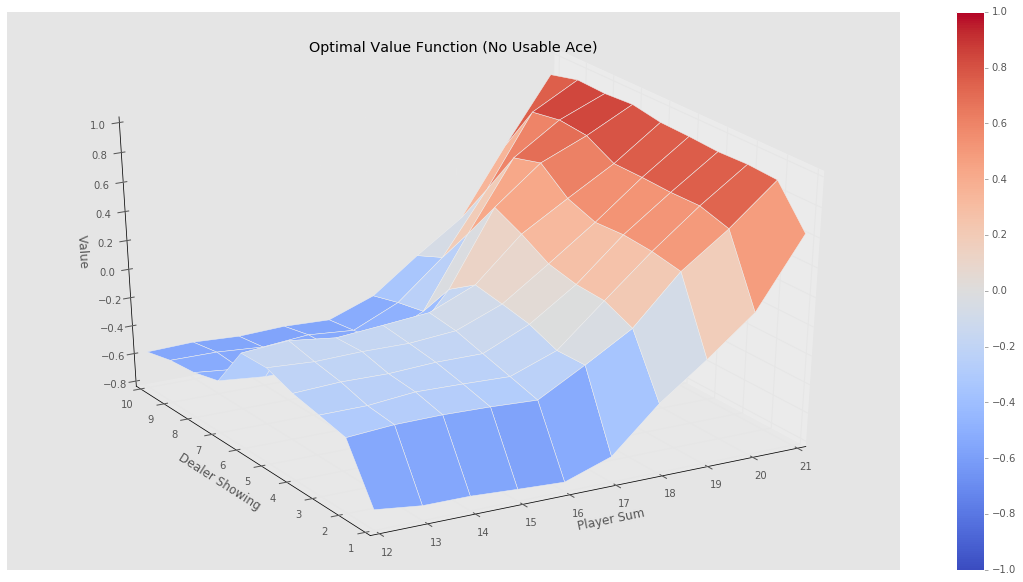

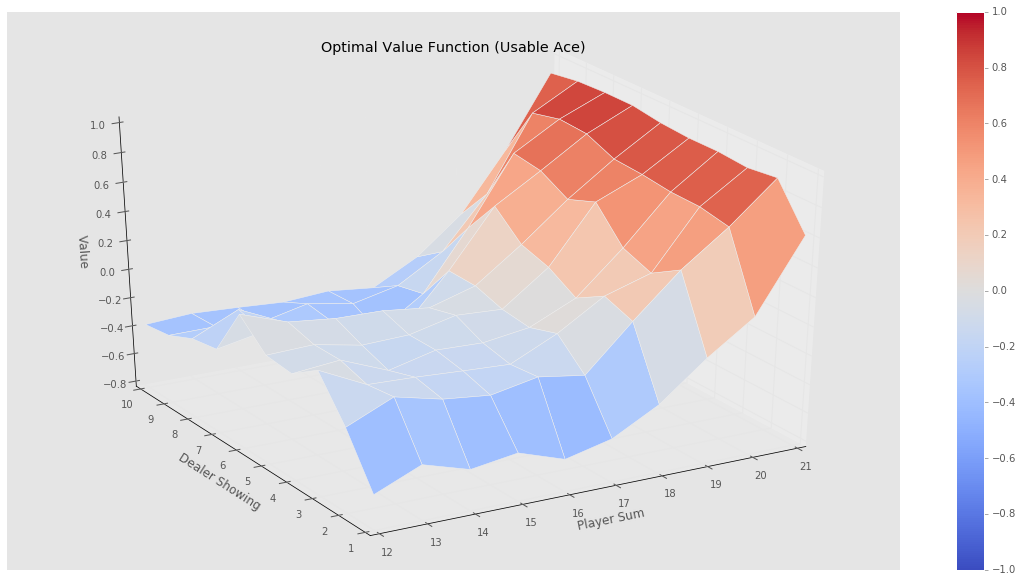

In [138]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
    print(len(state), end='')
plotting.plot_value_function(V, title="Optimal Value Function")

33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333

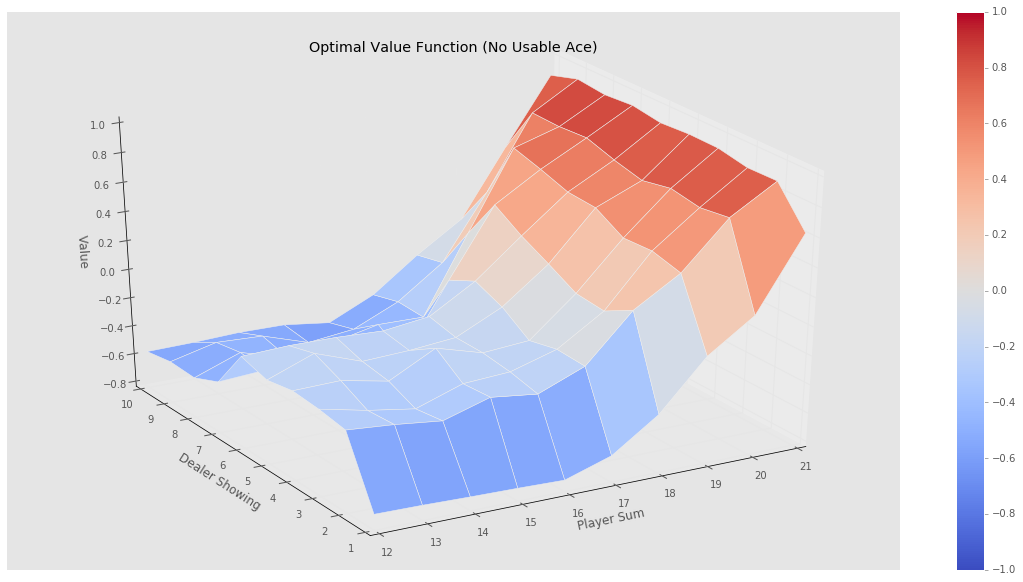

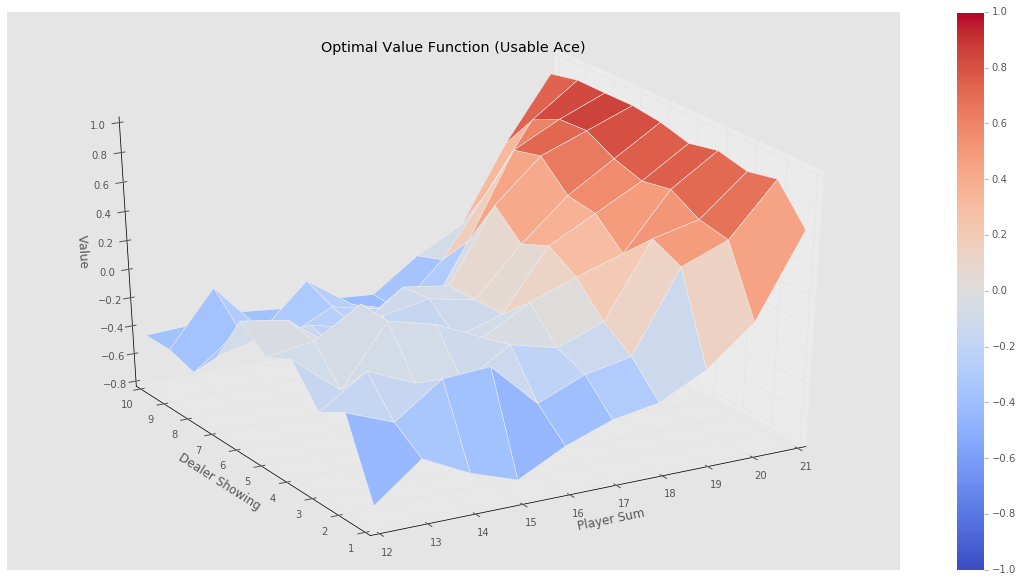

In [148]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
    print(len(state), end='')
plotting.plot_value_function(V, title="Optimal Value Function")

In [149]:
Q

defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>>,
            {(12, 1, False): array([-0.78212291, -0.72463768]),
             (12, 1, True): array([-0.77777778, -0.66666667]),
             (12, 2, False): array([-0.26078029, -0.52356021]),
             (12, 2, True): array([-0.14285714, -0.27777778]),
             (12, 3, False): array([-0.22891566, -0.52109181]),
             (12, 3, True): array([-0.625, -0.25 ]),
             (12, 4, False): array([-0.21259843, -0.47794118]),
             (12, 4, True): array([ -1.03448276e-01,   4.85722573e-17]),
             (12, 5, False): array([-0.24649299, -0.56455696]),
             (12, 5, True): array([-0.68421053, -0.08823529]),
             (12, 6, False): array([-0.18978102, -0.4973545 ]),
             (12, 6, True): array([-0.25      ,  0.05263158]),
             (12, 7, False): array([-0.47474747, -0.51428571]),
             (12, 7, True): array([-0.3       , -0.30769231]),
             (12, 8, False): array